# Readin Timestamps and Match to a Common Timeframe

Because both the camera and eye trackers are in free-run mode rather than triggered, we have to match the timestamps between the multiple collection devices post-hoc.  This involves first converting their timestamps from internal device time to Unix time. Next, we create a common timestamp set that is uniformly measured in time. Finally, we match each device time to its nearest common timestamp time, repeating a frame in the case of dropped frames. 


## Dependencies

In [1]:
import os, stat
import numpy as np
import utils.run_analysis as ana
import matplotlib.pyplot as plt
import datatable as dt


## Parameters

In [2]:
base_dir = '/data_repo/bravo'
data_dir = os.path.join(base_dir, 'raw_data')
output_dir = os.path.join(base_dir, 'analysis')
target_fps = 200


## Fix Permissions
When collecting, jupyter has to run as SUDO for keyboard communication. This makes some files and folders with sudo permissions, even for read. 

In Terminal:
'sudo chmod -R 777 /data_repo/bravo'

## Specify Directories for Exmaple

In [3]:
example_subject = 'jf'
example_trial = 'cell_phone_1'
example_camera = 'cy'
trial_directory = os.path.join(data_dir, example_subject, example_trial, 'pre')

#ximea (scene cameras)
ximea_timestamp_file = os.path.join(trial_directory, 'scene_camera', f'timestamps_{example_camera}.tsv')
ximea_timesync_file = os.path.join(trial_directory, 'scene_camera', f'timestamp_camsync_{example_camera}.tsv')

#pupil (eye cameras)
#pupil_timestamp_file = os.path.join(trial_directory, 'eye_camera','000', 'pupil_timestamps.npy')
pupil_timestamp_file = os.path.join(trial_directory, 'eye_camera','000','exports','000','pupil_positions.csv')
pupil_annotations_file = os.path.join(trial_directory, 'eye_camera','000', 'annotation_timestamps.npy')

analysis_folder = os.path.join(output_dir, example_subject, example_trial,'')
try:
    os.makedirs(analysis_folder)
except:
    print('Folder Already Made!')

Folder Already Made!


## Convert to unified wall clock time

Ximea cameras collect in camera time. We need to sync this to Unix time

In [4]:
ximea_timestamps = ana.convert_ximea_time_to_unix_time(ximea_timestamp_file, ximea_timesync_file)

ximea_timestamp_converted_path = os.path.join(analysis_folder,f'timestamps_converted_{example_camera}.tsv')

#np.savetxt(od_ximea_timestamp_converted_path, od_ximea_timestamps, fmt='%10.5f', delimiter='\t')
np.savetxt(ximea_timestamp_converted_path, ximea_timestamps, fmt='%10.5f', delimiter='\t')

Time Elapsed: 135.3787317276001 seconds
Time Drift pre to post: 0.018285096399949907 seconds
1574810720.7608986


## Get Pupil Labs Worldcam Calibrated Data

Use Converted Pupil Labs Data Structure. This gaze data has been aligned in world cam (Realsense) coordinates. To do this, after recording, drag the pupil labs folder ('000') into pupilplayer, then export. This wil create a few new files in the 000 folder, as well as an 'exports' folder with these converted files inside.   

The generated 'pupil_gaze_positions.txt' file contains a wealth of information explaining the generated files and how to interpret them.  

Specifically, for the 'norm_position_x' and y, we need to map the coordinate system to world camera coordinates.
"We use a normalized coordinate system with the origin 0,0 at the bottom left and 1,1 at the top right"

In [5]:
pupil_positions = dt.fread(pupil_timestamp_file)

pupil_positions = pupil_positions[:,[0,1,2,4,5]]
pupil_positions[:5,:]

,pupil_timestamp,world_index,eye_id,norm_pos_x,norm_pos_y
,▪▪▪▪▪▪▪▪,▪▪▪▪,▪,▪▪▪▪▪▪▪▪,▪▪▪▪▪▪▪▪
0,1.57481e+09,0,0,0.55147,0.644426
1,1.57481e+09,0,1,0.31347,0.673982
2,1.57481e+09,0,1,0.313451,0.674713
3,1.57481e+09,0,0,0.551234,0.644198
4,1.57481e+09,0,1,0.313698,0.674803


In [6]:
pupil_eye_0 = np.array(pupil_positions)[np.where(np.array(pupil_positions)[:,2]==0)[0],:]
pupil_eye_1 = np.array(pupil_positions)[np.where(np.array(pupil_positions)[:,2]==1)[0],:]

## How Many Frames Were Lost/Skipped?

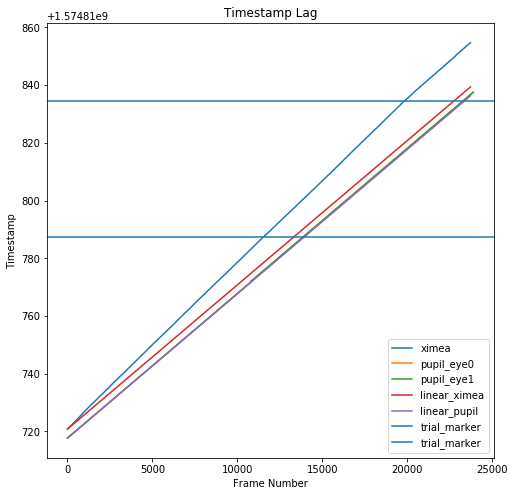

In [7]:
pupil_num='000'

pupil_ts_eye0 = pupil_eye_0[:,0]
pupil_ts_eye1 = pupil_eye_1[:,0]

#pupil_ts_gaze = np.load(os.path.join(pupil_save_dir_name, pupil_num, 'gaze_timestamps.npy'))
#pupil_ts_eye0 = np.load(os.path.join(pupil_save_dir_name, pupil_num, 'eye0_timestamps.npy'))
#pupil_ts_eye1 = np.load(os.path.join(pupil_save_dir_name, pupil_num, 'eye1_timestamps.npy'))
pupil_annotations = np.load(pupil_annotations_file)

#ximea timestamps
with open(ximea_timestamp_converted_path, 'r') as f:
    timestamps_ximea = list(zip(line.strip().split('\t') for line in f))
    timestamps_ximea = np.squeeze(np.array(timestamps_ximea[1:]).astype('float'))
    timestamps_ximea = timestamps_ximea[:,-1]

linear_ximea = np.arange(0,len(timestamps_ximea)*0.005, 0.005)+timestamps_ximea[0]
linear_pupil = np.arange(0, len(timestamps_ximea)*0.005, 0.005)+pupil_ts_eye0[0]

plt.figure(figsize=(8,8))
plt.plot(timestamps_ximea, label='ximea')
plt.plot(pupil_ts_eye0, label='pupil_eye0')
plt.plot(pupil_ts_eye1, label='pupil_eye1')
#plt.plot(pupil_ts_gaze, label='gaze')
# plt.plot(pupil_ts_eye0, label='vid_eye0')
# plt.plot(pupil_ts_eye1, label='vid_eye1')
plt.plot(linear_ximea, label='linear_ximea')
plt.plot(linear_pupil, label='linear_pupil')

[plt.axhline(pupil_annotations[i], label='trial_marker') for i in range(len(pupil_annotations))]
#plt.axhline(pupil_annotations[1], label='trial_marker')

plt.legend()
plt.xlabel('Frame Number')
plt.ylabel('Timestamp')
plt.title('Timestamp Lag')
plt.legend()

We've lost a decent number of ximea frames, but pupil looks pretty good. Lets ID where the missing frames are first.

In [8]:
dt = timestamps_ximea[1:] - timestamps_ximea[:-1]
pfl = len(dt[dt >= 0.01])/len(dt)
print(f'Percentage Frames Dropped: {pfl}')

Percentage Frames Dropped: 0.03426620585012223


## Task Marking

*** FOR THIS PRELIMINARY DATA WHICH HAS NO TASK END MARKER ONLY ***   
*** When we move to a second calibration AFTER the task, need to change this code ***

The LAST pupil annotation should be the beginning of the task, and all data AFTER that is task data. Mark it as such.

In [9]:
if(example_trial == 'cell_phone_1'):
    start_task_time = pupil_annotations[-2]
    end_task_time = pupil_annotations[-1]
else:
    start_task_time = pupil_annotations[-1]
    end_task_time = timestamps_ximea[-1]

## Create Non-Lossy Timeframe & Assign Pupil & Ximea Frames to it
For now, frame numbers are simply repeated if there is a frame drop. This seems better than interpolating an image, but will ask Bruno about this

In [10]:
start_timestamp = np.max((timestamps_ximea[0], pupil_ts_eye0[0], pupil_ts_eye1[0]))
end_timestamp = np.min((timestamps_ximea[-1], pupil_ts_eye0[-1], pupil_ts_eye1[-1]))
common_timeline = np.arange(start_timestamp, end_timestamp, 1./target_fps)

In [11]:
ximea_common_timeline_match = np.zeros_like(common_timeline)
pupil_eye0_common_timeline_match = np.zeros_like(common_timeline)
pupil_eye1_common_timeline_match = np.zeros_like(common_timeline)
during_calibration = np.zeros_like(common_timeline)
during_task = np.zeros_like(common_timeline)

for i, t in enumerate(common_timeline):
    ximea_common_timeline_match[i] = np.argmin(np.abs(timestamps_ximea - t))
    pupil_eye0_common_timeline_match[i] = np.argmin(np.abs(pupil_ts_eye0 - t))
    pupil_eye1_common_timeline_match[i] = np.argmin(np.abs(pupil_ts_eye1 - t))
    if((t > start_task_time) and (t < end_task_time)):
        during_task[i] = 1
    #mark calibration later
        #during_calibration

In [12]:
nframes = len(np.where(during_task ==1)[0])
print(f'{nframes/target_fps} Seconds of Task')

47.11 Seconds of Task


## Save Timeframe and Marks for Later Use

Our new timeline can be used to align pupil labs data to our camera data and create movies for spatiotemporal analysis!

In [14]:
common_timeline_table = np.array((common_timeline, ximea_common_timeline_match, pupil_eye0_common_timeline_match, pupil_eye1_common_timeline_match, during_task, during_calibration)).T
common_timeline_table_colnames = 'common_timeline\tximea_frame\tpupil_eye0_frame\tpupil_eye1_frame\tduring_task\tduring_calibration'
common_timeline_file = os.path.join(analysis_folder,'common_timeline.tsv')
np.savetxt(common_timeline_file, common_timeline_table, delimiter='\t', header=common_timeline_table_colnames)

## Run Script on All Trials

I put all the code in a nice script! Run this script on all our trials to create respective timestamps for each

In [15]:
import itertools as it
import read_match_timestamps as rmt
import imp
imp.reload(rmt)

subjects = ['jf']
tasks = ['cell_phone', 'laptop'] 
repititions = ['1','2','3']
iterator = it.product(subjects, tasks, repititions)

for iteration in iterator:
    subject, task, rep = iteration
    trial = f'{task}_{rep}'
    print('*')
    if(os.path.isdir(os.path.join(base_dir,'raw_data', subject, trial))):
        table = rmt.read_match_timestamps(base_dir, target_fps, subject, trial, num_cameras=1)

*
Folder /data_repo/bravo/analysis/jf/cell_phone_1/ Already Made!
Time Elapsed: 135.3787317276001 seconds
Time Drift pre to post: 0.018285096399949907 seconds
1574810720.7608986
Task Lasted: 47.111611127853394 seconds.
*
Folder /data_repo/bravo/analysis/jf/cell_phone_2/ Already Made!
Time Elapsed: 135.2961688041687 seconds
Time Drift pre to post: 0.018304411831309153 seconds
1574810921.4236894
Task Lasted: 72.01901483535767 seconds.
*
Folder /data_repo/bravo/analysis/jf/cell_phone_3/ Already Made!
Time Elapsed: 136.0369143486023 seconds
Time Drift pre to post: 0.015845579397705478 seconds
1574811110.9803076
Task Lasted: 82.39471745491028 seconds.
*
Folder /data_repo/bravo/analysis/jf/laptop_1/ Already Made!
Time Elapsed: 136.31205368041992 seconds
Time Drift pre to post: 0.015955095580238776 seconds
1574811439.918789
Task Lasted: 73.00651121139526 seconds.
*
Folder /data_repo/bravo/analysis/jf/laptop_2/ Already Made!
Time Elapsed: 136.78098344802856 seconds
Time Drift pre to post: 0.01